<a href="https://colab.research.google.com/github/mavilacamilla/Computational-Simulation/blob/main/CM_Parallel_computing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parallel computing

When we want to perform very time-consuming analyses, it's useful to know some tricks to speed up computation.

### 1. Optimize
One way to do it is to optimize your code:
* try to write as much as you can as array operations, instead of using `for` loops,
* don't keep a lot of variables in memory that you won't use,
* reuse the same arrays (especially if large) instead of creating new ones,
* avoid repeating the same calculations more than once,
* and whenever possible, try to write "de-nested" code (that is, avoid a lot of nested if/else clauses).

For the kind of analyses we have been running, there's not much we can do in terms of the above, and optimization only helps up to a point - after that, gains are minimal even if you put a lot of effort into it.

### 2. Use faster programming languages
So a second way would be to use a faster, low-level, programming language to write your functions, such as C or Fortran. Writing your whole code in these languages is very painful, and can take a lot longer than waiting for your code to run.

A nice solution is to write just the "core" function of your code, and use this faster version. For instance, when solving ODE's, you could write just the function that calculates the equations of the system in C and use it inside your Python code. To do that, you need to learn both how to code your function in C, and how to compile it in a way that interfaces with Python. That's a bit tricky, and depends on a lot of tools you need to install in your computer, so we won't cover it here.

### 3. Parallelize your code
Most computers now have several "cores", that is, they have multiple CPUs and thus are able to run different processes at the same time (in the before times, programs running in a single CPU "at the same time" were actually just switching between them so quickly you didn't notice).

The idea of parallelization is to break your analyzes into many different pieces (for instance, sets of parameters) that can be run more or less independently of each other, and then set up your code to run them in exactly that way, taking advantage of the multiple CPUs you have available. So if you have 4 CPUs, you can make the same calculations 4 times faster! In practice you never get exactly 4 times, because setting up those 4 processes and distributing the processes and so on take a bit of time.

Parallelization can be tricky if you need the different processes to communicate between themselves (the result of one affects the other). Fortunately, many problems we deal with are of the type called **embarassingly parallel**: all processes are completely independent from the others.

Here we'll see a practical way of doing that in Python, using the built-in library **multiprocessing**.

In [ ]:
from time import sleep
import multiprocessing as mp

def delayed_square(x):
    # sleep tells the computer to wait for this time (in seconds)
    sleep(0.2)
    return x*x

In [ ]:
%%time
# %% time measures the time taken to run this cell
data = list(range(8))
result = list(map(delayed_square, data))
print(result)

[0, 1, 4, 9, 16, 25, 36, 49]
CPU times: user 4.82 ms, sys: 543 µs, total: 5.36 ms
Wall time: 1.6 s


In [ ]:
# let's count how many CPUs we have available
mp.cpu_count()

2

In [ ]:
%%time
data = list(range(8))

# Pool() creates a pool of processes that can work in parallel
# it automatically detects the number of CPUs, but you can set it by hand,
# too with
# p = mp.Pool(processes=2)
# Note: using more processes than your number of CPUs is counterproductive! But
# if you have a lot (like 8 or 16) it's useful to leave one or two CPUs free to
# perform other background tasks.

p = mp.Pool()
result = p.map(delayed_square, data)
print(result)

[0, 1, 4, 9, 16, 25, 36, 49]
CPU times: user 24.7 ms, sys: 15.1 ms, total: 39.7 ms
Wall time: 887 ms


In [ ]:
# after calculations are done, we close the pool
# this is done automatically when the program finishes, but in a notebook this
# is less clear
p.close()

## A practical example

Let's try do adapt the code from last class to explore a model over a single parameter. For each parameter, we want to find the minimum and maximum values of each variable. The results for each parameter don't depend on the results for other parameters: this is a typical embarassingly parallel problem.

We first do everything without parallelization.

In [ ]:
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as pt

def RM(y, t, r, K, a, h, e, d):
    return np.array([ y[0] * ( r*(1-y[0]/K) - a*y[1]/(1+a*h*y[0]) ),
                      y[1] * (e*a*y[0]/(1+a*h*y[0]) - d) ])

t = np.arange(0, 6000, 1.)
# initial condition
y0 = np.array([1, 1.])

In [ ]:
# range of values of K
KK = np.arange(.5, 20, .5)

ymin = []
ymax = []
# loop over the values of K (KK)
for K in KK:
    # redefine the parameters using the new one
    # order: r,  K,  a,  h,   e,   d
    pars =  (1., K, 1., 0.1, 0.1, 0.1)
    y = odeint(RM, y0, t, pars)
    ymin.append(y[-1000:,:].min(axis=0))
    ymax.append(y[-1000:,:].max(axis=0))
# convert the lists into arrays
ymin = np.array(ymin)
ymax = np.array(ymax)

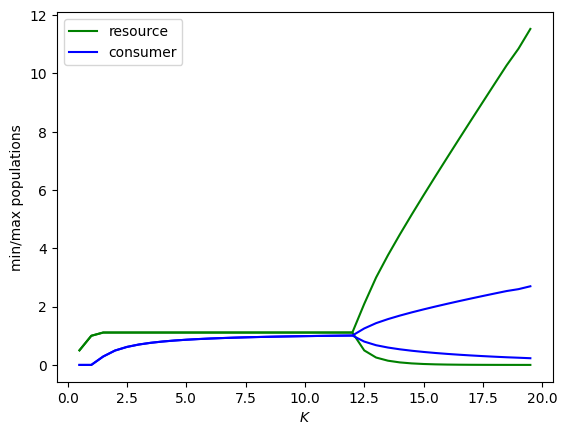

In [ ]:
# plot
pt.plot(KK, ymin[:,0], 'g', label='resource')
pt.plot(KK, ymax[:,0], 'g')
pt.plot(KK, ymin[:,1], 'b', label='consumer')
pt.plot(KK, ymax[:,1], 'b')
pt.xlabel('$K$')
pt.ylabel('min/max populations')
pt.legend(loc='best')

In [ ]:
# let's rework this example to write it using map()
def helper(K):
    pars =  (1., K, 1., 0.1, 0.1, 0.1)
    y = odeint(RM, y0, t, pars)
    ymin = y[-1000:,:].min(axis=0)
    ymax = y[-1000:,:].max(axis=0)
    return (ymin, ymax)


In [ ]:
%%time
KK = np.arange(.5, 20, .5)
results = np.array(list(map(helper, KK)))

In [ ]:
print(results.shape)
print(results[0,:,:])

In [ ]:
# plotting
pt.plot(KK, results[:,0,0], 'g', label='resource')
pt.plot(KK, results[:,1,0], 'g')
pt.plot(KK, results[:,0,1], 'b', label='consumer')
pt.plot(KK, results[:,1,1], 'b')
pt.xlabel('$K$')
pt.ylabel('min/max populations')
pt.legend(loc='best')

### Parallel version

In [ ]:
%%time
KK = np.arange(.5, 20, .5)
p = mp.Pool()
results = np.array(list(p.map(helper, KK)))
p.close()

In [ ]:
print(results.shape)
print(results[0,:,:])

In [ ]:
# plotting
pt.plot(KK, results[:,0,0], 'g', label='resource')
pt.plot(KK, results[:,1,0], 'g')
pt.plot(KK, results[:,0,1], 'b', label='consumer')
pt.plot(KK, results[:,1,1], 'b')
pt.xlabel('$K$')
pt.ylabel('min/max populations')
pt.legend(loc='best')

## A more complicated problem

Now let's try to do the same with the case when two parameters were varied. Now the issue is that our function will have to take two parameters.

In [ ]:
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as pt

def RM(y, t, r, K, a, h, e, d):
    return np.array([ y[0] * ( r*(1-y[0]/K) - a*y[1]/(1+a*h*y[0]) ),
                      y[1] * (e*a*y[0]/(1+a*h*y[0]) - d) ])

def check_regime(y):
    if y[:,1].max() < 1e-5:
        return 1
    elif np.all(y.max(axis=0) - y.min(axis=0) < 1e-5):
        return 2
    else:
        return 3

def solve_classify(a, h):
    # order: r,  K,  a, h,   e,   d
    pars =  (1., 10, a, h, 0.1, 0.1)

    t = np.arange(0, 5000, .1)
    y0 = np.array([0.1, 0.1])

    y = odeint(RM, y0, t, pars)
    regime = check_regime(y[-1000:,:])
    return regime


In [ ]:
a = np.arange(0.01, 1.6, 0.1)
h = np.arange(0.01, 0.9, 0.05)

# 2d grid
X, Y = np.meshgrid(a, h)

# remember to vectorize the function!
solve_classify_vec = np.vectorize(solve_classify)

In [ ]:
%%time
# now this takes a bit of time
Z = solve_classify_vec(X, Y)

In [ ]:
# this does the plotting
pt.pcolor(X, Y, Z)
pt.xlabel('a')
pt.ylabel('h')
pt.colorbar(ticks=[1,2,3])

In [ ]:
%%time
# the previous attempt was already a bit optimized by vectorization, maybe
# this is a better comparison point?
Z = np.zeros(X.shape)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        Z[i, j] = solve_classify(X[i, j], Y[i, j])

### Parallel version

Our job was to take each pair of values (x, y) from the 2d arrays X, Y and run the function `solve_classify` on it.

The `map` function takes only a single value, not a pair! If we want to pass multiple arguments, we have to use a similar function called `starmap` that passes any number of arguments, but now our list of parameters should be a **list of pairs**. There's a simple way to build that using the appropriately named function `zip`.



In [ ]:
# using zip:
l1 = np.arange(0, 10, 2)
l2 = np.arange(1, 11, 2)
print("l1: ", l1)
print("l2: ", l2)
print(zip(l1, l2))
print(list(zip(l1, l2)))

In [ ]:
# now our arrays are 2d, not lists! We have to make them 1d first
# we do this with flatten:
print(X)
print("shape: ", X.shape)

In [ ]:
X_flat = X.flatten()
print(X_flat)
print("shape: ", X_flat.shape)

In [ ]:
# we recover the original structure with reshape:
X_orig = X_flat.reshape(X.shape)
print(X_orig)
print("shape: ", X_orig.shape)

Now let's solve our problem...

In [ ]:
%%time
p = mp.Pool()
result = p.starmap(solve_classify, zip(X.flatten(), Y.flatten()))
# the result is a 1d list, let's put it in the original shape
Z = np.array(result).reshape(X.shape)
p.close()

In [ ]:
# this does the plotting
pt.pcolor(X, Y, Z)
pt.xlabel('a')
pt.ylabel('h')
pt.colorbar(ticks=[1,2,3])